In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
FontProp = fm.FontProperties(family='serif', weight='semibold', style='normal', size=12)
from tqdm import trange
from tabulate import tabulate
from termcolor import colored
from IPython.display import display, Latex, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data Augmentation

Given the model 
$$p(\theta,z|\mathbf{y}_{\mathrm{obs}}),$$
we can obtain the **complete-data posterior distribution** (z is latent variables or missing data)
$$p(\theta|\mathbf{y}_{\mathrm{obs}}, z),$$
and the **conditional predictive distribution**
$$p(z|\mathbf{y}_{\mathrm{obs}}, \theta).$$
Our goal is to draw samples from $p(\theta|\mathbf{y}_{\mathrm{obs}})$ to augment $\theta$, where
$$
p(\theta|\mathbf{y}_{\mathrm{obs}})=\int p(\theta,z|\mathbf{y}_{\mathrm{obs}})dz. 
$$

## The original DA algorithm (multiple imputation)

I-step: Draw samples $\{\theta^{(k,j)}\}_{j=1}^m$ from $p_k(\theta|\mathbf{y}_{\mathrm{obs}})$, and obtain $\{z^{(k,j)}\}_{j=1}^m$, where $z^{(k,j)}\sim p(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k,j)})$. 

P-step: Update the posterior:
$$
p_{k+1}(\theta|\mathbf{y}_{\mathrm{obs}})=\frac{1}{m}\sum_{j=1}^mp(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k,j)}).
$$

## The DA algorithm

Some insights about the original DA algorithm:
* The P-step can be integrated into the I-step. 
* The I-step can be modified in the following way:

(1) Draw samples $\{\theta^{(k,j)}\}_{j=1}^m$ from $p_k(\theta|\mathbf{y}_{\mathrm{obs}})$, where
$$
p_k(\theta|\mathbf{y}_{\mathrm{obs}})=\frac{1}{m}\sum_{j=1}^mp(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k-1,j)}). 
$$
(2) Draw samples $\{z^{(k,j)}\}_{j=1}^m$ from $p_k(z|\mathbf{y}_{\mathrm{obs}})$, where
$$
p_k(z|\mathbf{y}_{\mathrm{obs}})=\frac{1}{m}\sum_{j=1}^mp(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k,j)}). 
$$
But the step (2) is based on **stratification**. 

What if we let the step (1) to be based on stratification too? In that case we would have

(1) Draw samples $\{\theta^{(k,j)}\}_{j=1}^m$, where $\theta^{(k,j)}\sim p(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k-1,j)})$. 

(2) Draw samples $\{z^{(k,j)}\}_{j=1}^m$, where $z^{(k,j)}\sim p(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k,j)})$. 

And we find that this is equivalent to do $m$ **parallel Gibbs**! 

So why not just simplify it to be one single Gibbs:

(1) Draw sample $\theta^{(k)}$, where $\theta^{(k)}\sim p(\theta|\mathbf{y}_{\mathrm{obs}},z^{(k-1)})$. 

(2) Draw sample $z^{(k)}$, where $z^{(k)}\sim p(z|\mathbf{y}_{\mathrm{obs}},\theta^{(k)})$. 

This is the **standard DA algrithm**. We can also draw $z$ first, just choose the convenient one. 

## Example: grouped count data (missing data)

Given the observed data (\# of passages, \# of observations): \{(0,139),(1,128),(2,55),(3,25),(4+,13)\}. \# is number.

Assume the **Poisson model**: 
$$
P(X=x)=\frac{e^{-\lambda}\lambda^x}{x!},\; x=0,1,\dots
$$
for the \# of passages. Try to estimate $\lambda$. 

There are $347=139+128+55+25$ observations $\mathbf{x}_{\mathrm{obs}}$ and 13 missing data $z_{1:13}$. 

If we assume the prior $p(\lambda)\propto 1/\lambda$, the model is
$$
p(\lambda,z_{1:13}|\mathbf{x}_{\mathrm{obs}})\propto\frac{1}{\lambda}e^{-347\lambda}\lambda^{128+55\times2+25\times3}\prod_{j=1}^{13}\frac{e^{-\lambda}\lambda^{z_j}}{z_j!}\mathbf{1}(z_j\ge4). 
$$
so, we can obtain the complete-data posterior distribution
$$\lambda|\mathbf{x}_{\mathrm{obs}}, z_{1:13}\sim Gamma(313+\sum_{j=1}^{13}z_j,360),$$
and the conditional predictive distribution 
$$p(z_j|\mathbf{y}_{\mathrm{obs}}, \lambda)=p(z_j|\lambda)\propto\frac{e^{-\lambda}\lambda^{z_j}}{z_j!}\mathbf{1}(z_j\ge4).$$

Based on the Gibbs, we can obtain the samples $\{\lambda^{(i)},z_{1:13}^{(i)}\}_{i=1}^{n}$. 

* Assume $\lambda^{(0)}=\frac{313+13\times4}{360}$. Compare the two estimators of $\lambda$: (1) $\hat{\lambda}_1=\frac{1}{n}\sum_{i=1}^n\lambda^{(i)}$; (2) $\hat{\lambda}_2=\frac{1}{n}\sum_{i=1}^n\frac{313+\sum_{j=1}^{13}z_j^{(i)}}{360}$. 

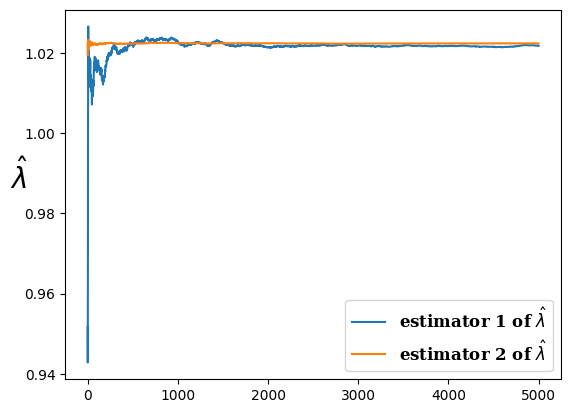

In [2]:
def trunc_poisson(lamda, min_val, size):  # sample from trunc_poisson distribution
    cut = st.poisson(mu=lamda).cdf(min_val - 1)
    u = st.uniform(loc=cut, scale=1 - cut).rvs(size=size)
    return st.poisson(mu=lamda).ppf(u)

n = 5000
z_13 = np.zeros([n, 13])
lambdas = np.zeros(n+1)
lambdas[0] = (313 + 13*4) / 360
for i in range(n):
    z_13[i] = trunc_poisson(lamda=lambdas[i], min_val=4, size=13)
    lambdas[i + 1] = st.gamma(a=313 + sum(z_13[i]), scale=1/360).rvs()
    
z13s = (313 + z_13.sum(axis=1)) / 360

lambda_cummean = np.cumsum(lambdas[1:]) / (np.arange(n) + 1)
z_13_cummean   = np.cumsum(z13s) / (np.arange(n) + 1)

plt.plot(lambda_cummean, label='estimator 1 of $\hat{\lambda}$')
plt.plot(z_13_cummean, label='estimator 2 of $\hat{\lambda}$')
plt.ylabel('$\hat{\lambda}$', font='cmb10', rotation='horizontal', fontsize=20) 
plt.legend(prop=FontProp)
plt.show()

We can see that the two estimators have similar results for $\lambda$.

## Example: probit model (latent variables)

Other than the logistic model, another classic model in binary classification is called the **probit model**:
$$
P(Y=1|x)=\Phi(x^T\beta),
$$
where $Y$ is a binary label, x is the vector of features, $\beta$ is the model parameter and $\Phi$ is the cdf of the standard normal distribution. 

Given data $\{(y_1,x_1),\dots,(y_m,x_m)\}$, and the non-informative prior $p(\beta)\propto 1$, the model is
$$
p(\beta|y_{1:m},x_{1:m})\propto p(y_{1:m},\beta|x_{1:m})=p(y_{1:m}|\beta,x_{1:m})p(\beta)=\prod_{j=1}^m\Phi(x_j^T\beta)^{y_j}(1-\Phi(x_j^T\beta))^{1-y_j}, 
$$
and we can apply the Random Walk to do inference about $\beta$. 

Another way is to use the data augmentation with the Gibbs sampler. To achieve this, we assume the latent variables $z_j=x_j^T\beta+\varepsilon_j$, $j=1,\dots,m$, where $\varepsilon_j\sim N(0,1)$. And we assume $y_j$ depends on $z_j$ deterministically that $y_j=\mathbf{1}(z_j>0)$. To see why this assumption holds, note $\varepsilon$ follows $N(0,1)$ 
$$
P(Y=1|x)=P(\mathbf{1}(Z>0)=1|x)=P(x^T\beta+\varepsilon>0)=P(-\varepsilon<x^T\beta)=\Phi(x^T\beta). 
$$
So, the augmented model is
\begin{align}
p(\beta,z_{1:m}|y_{1:m},x_{1:m})&\propto p(y_{1:m},z_{1:m},\beta|x_{1:m})=p(y_{1:m}|z_{1:m})p(z_{1:m}|\beta,x_{1:m})p(\beta)\\
&=\prod_{j=1}^m(\mathbf{1}(z_j>0)\mathbf{1}(y_j=1)+\mathbf{1}(z_j\le0)\mathbf{1}(y_j=0))\exp(-\frac{(z_j-x_j^T\beta)^2}{2}).
\end{align}
Easy to derive that
$$
\beta|z_{1:m},y_{1:m},x_{1:m}\sim N((X^TX)^{-1}X^Tz_{1:m},(X^TX)^{-1}), 
$$
where $X=[x_{1:m}]_{m\times p}$, and
$$
p(z_j|\beta,y_{1:m},x_{1:m})\propto(\mathbf{1}(z_j>0)\mathbf{1}(y_j=1)+\mathbf{1}(z_j\le0)\mathbf{1}(y_j=0))\exp(-\frac{(z_j-x_j^T\beta)^2}{2}).
$$

Based on the Gibbs, we can obtain the samples $\{\beta^{(i)},z_{1:m}^{(i)}\}_{i=1}^{n}$. 

* $x\sim N(\mathbf{0},I_2)$, draw 1000 samples for $x$, and derive 1000 $y$ from the probit model with $\beta_0=[-1,2]^T$. Draw 2000 samples of $\beta$ given $x,y$. 
<br>Compare the $\beta$ trajectories of the Random Walk and Gibbs. Which one is better? 

In [3]:
N = 1000
X = st.multivariate_normal(mean=[0,0]).rvs(N)
beta0 = [-1, 2]
y = 1.0 * (X.dot(beta0) + st.norm.rvs(size=N) > 0)

def logtarget(beta):
    tmp = y * np.log(st.norm.cdf(X.dot(beta))) + (1 - y) * np.log(1 - st.norm.cdf(X.dot(beta)))
    return tmp.sum()

def trunc_norm(beta):
    lb = np.log(y == 1)
    ub = -np.log(y != 1)
    loc = X.dot(beta)
    return st.truncnorm(a=lb - loc, b=ub - loc, loc=loc).rvs()

def RW(size, step):
    beta = np.zeros([size + 1, 2])
    for i in range(size):
        beta_new = beta[i] + st.norm(scale=step).rvs(size=2)
        diff = logtarget(beta_new) - logtarget(beta[i])
        beta[i + 1] = beta_new if np.log(st.uniform.rvs()) <= diff else beta[i]      
    return beta

def Gibbs(size):
    beta = np.ones([size + 1, 2])
    Z = np.ones([size, y.size])
    invXTX = np.linalg.inv(X.T.dot(X))
    for i in range(size):
        Z[i] = trunc_norm(beta[i])
        #beta[i + 1] = st.multivariate_normal(mean=invXTX.dot(X.T).dot(Z[i]), cov=invXTX).rvs()  # perform bad !
        beta[i + 1] = np.random.default_rng(i+1234).multivariate_normal(mean=invXTX.dot(X.T).dot(Z[i]), cov=invXTX)
    return beta

| Method   |     beta0 | var                   |   beta1 | var                  |
|----------|-----------|-----------------------|---------|----------------------|
| RW:      | -0.968811 | 0.0069747830216986655 | 1.94154 | 0.01619369337124874  |
| Gibbs:   | -0.970898 | 0.009691978528110599  | 1.93545 | 0.015002858170065986 |
| Truth:   | -1        | ---                   | 2       | ---                  |


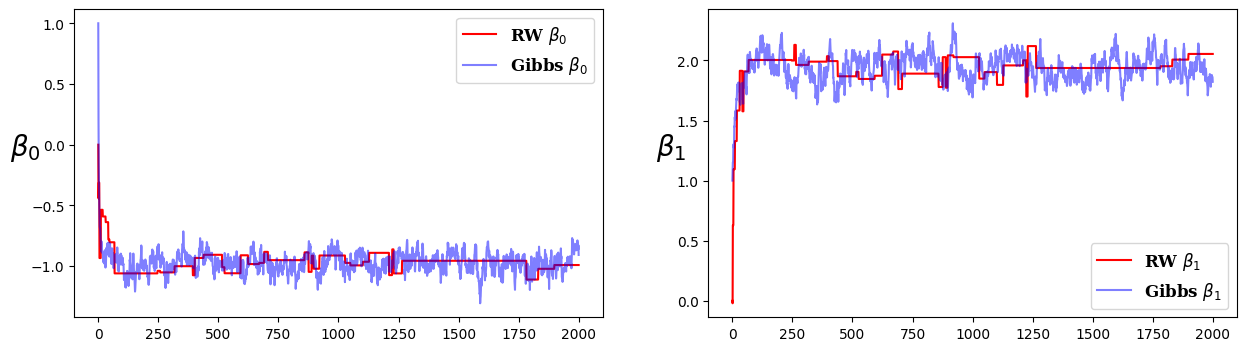

In [5]:
beta_RW = RW(2000, 0.8)
beta_Gibbs = Gibbs(2000)

#np.set_printoptions(precision = 4)
table = []
table.append(('RW: ', beta_RW[:, 0].mean(), beta_RW[:, 0].var(), beta_RW[:, 1].mean(), beta_RW[:, 1].var()))
table.append(('Gibbs: ', beta_Gibbs[:, 0].mean(), beta_Gibbs[:, 0].var(), beta_Gibbs[:, 1].mean(), beta_Gibbs[:, 1].var()))
table.append((colored('Truth:', 'blue', attrs=['bold']), beta0[0], '---', beta0[1], '---'))
print(tabulate(table, headers=['Method','beta0', 'var', 'beta1', 'var'], tablefmt='github'))

fig, ax = plt.subplots(1, 2, figsize=[15, 4])
ax[0].set_ylabel('$\\beta_0$', rotation='horizontal', fontsize=20) 
ax[0].plot(beta_RW[:, 0], label='RW $\\beta_0$', color='r')
ax[0].plot(beta_Gibbs[:, 0], label='Gibbs $\\beta_0$', color='b', alpha=0.5)
ax[1].set_ylabel('$\\beta_1$', rotation='horizontal', fontsize=20) 
ax[1].plot(beta_RW[:, 1], label='RW $\\beta_1$', color='r')
ax[1].plot(beta_Gibbs[:, 1], label='Gibbs $\\beta_1$', color='b', alpha=0.5)

for a in ax.flatten(): a.legend(prop=FontProp)
fig.show()

# Simulating Annealing

For any distribution $\pi(x)$, its negative log function is called the corresponding **energy function**:
$$
h(x)=-\log(\pi(x)).
$$
In the simulated annealing, based on some intuitions from physics, we redefine the distribution with a new parameter $T$ - **the temperature**: 
$$
\pi_T(x)=\exp(-\frac{h(x)}{T})(=\pi(x)^{1/T}). 
$$

An example:

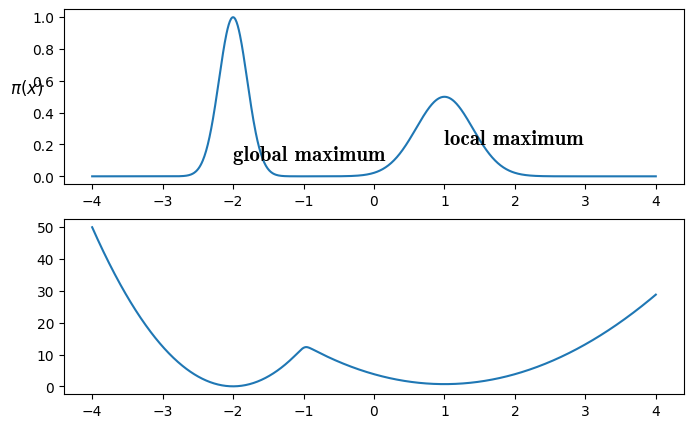

In [6]:
pi = lambda x: 0.5 * st.norm(loc=-2, scale=0.2).pdf(x) + 0.5 * st.norm(loc=1, scale=0.4).pdf(x)
h = lambda x: -np.log(pi(x))

grid_x = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots(2, 1, figsize=[8, 5])
ax[0].text(-2, 0.1, 'global maximum', font='cmb10', fontsize=15)
ax[0].text(1, 0.2, 'local maximum', font='cmb10', fontsize=15)
ax[0].set_ylabel('$\pi(x)$', loc='center', font='cmb10', rotation='horizontal', fontsize=12) 
ax[0].plot(grid_x, pi(grid_x))
ax[1].plot(grid_x, h(grid_x))
plt.show()

What if $T$ goes to 0 or infinity?

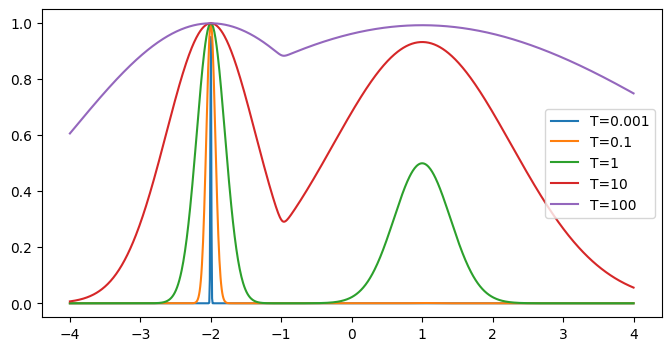

In [7]:
piT = lambda x, T: np.exp(-h(x) / T)
hight = piT(-2, T=1)

grid_x = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(grid_x, piT(grid_x, T=0.001) * hight / piT(-2, T=0.001), label='T=0.001')
ax.plot(grid_x, piT(grid_x, T=0.1) * hight / piT(-2, T=0.1), label='T=0.1')
ax.plot(grid_x, piT(grid_x, T=1), label='T=1')
ax.plot(grid_x, piT(grid_x, T=10) * hight / piT(-2, T=10), label='T=10')
ax.plot(grid_x, piT(grid_x, T=100) * hight / piT(-2, T=100), label='T=100')
ax.legend()
plt.show()

The idea of **Simulating Annealing** is simply to run the **Random Walk** against a redefined target distribution $\pi_T(x)$, and gradually reduce $T$ as the algorithm proceeds. As the temperature decreases, the region around the maximum point would have higher and higher probability to capture the last sample point. 

* Run the Random Walk against the above distribution with Gaussian kernel and step size 2, and set $T=2/n$, where $n$ is iteration number. Begin the walk at the local maximum $x_0=3$ and the total iteration time is $N=300$. What's the probability that the last sample point is trapped by the area around the global maximum point $x=-2$. Run 5 repetitions to estimate this probability and draw all the trajectories of the Random Walk. 

Walk step size should be large, or it will be trapped in local maximum! stop at 1 in this example



100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


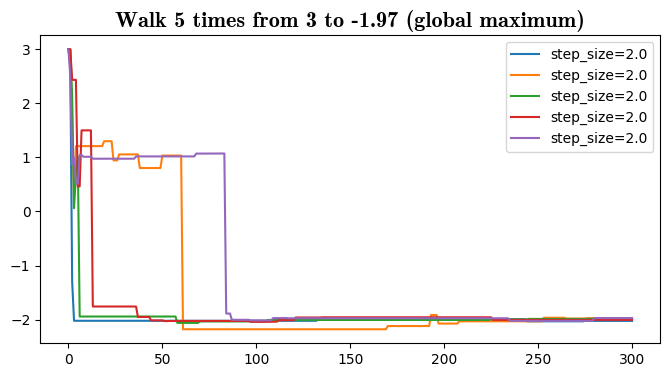

In [22]:
print(colored('Walk step size should be large, or it will be trapped in local maximum! stop at 1 in this example', 'blue', attrs=['bold']))
def annealing(N, step_size):
    x = np.ones(N+1) + 2
    for i, u in enumerate(st.uniform.rvs(size = N)):
        T = 2 / (i+1)
        x_new = x[i] + st.norm(scale=step_size).rvs()  # if scale (step size) is small, it will walk to local maximum 1
        ratio = piT(x_new, T) / piT(x[i], T)
        x[i+1] = x_new if u <= ratio else x[i]
    return x

rep, N = 5, 300
step_size = 2
X = np.array([annealing(N, step_size) for i in trange(rep)])

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
ax.set_title('Walk %d times from %d to %.2f (global maximum)'%(rep, X[0][0], X[-1][-1]), fontname='cmb10', fontsize=16)
ax.plot(X.T, label='step_size=%.1f'%step_size)
ax.legend()
plt.show()

**Think further:** Try different parameter settings to see how different parameters influence the annealing. 
<br>We can see when walk from 3, it stops at 1 for some time, then walk to -2. If the step size is small it will be trapped in 1, so scale should be large enough


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


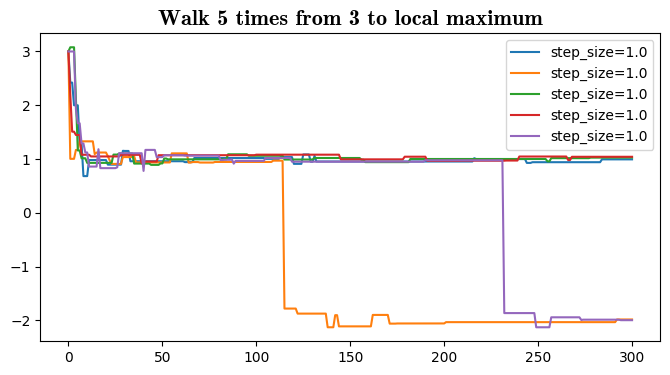

In [19]:
step_size = 1
X = np.array([annealing(N, step_size) for i in trange(rep)])

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
ax.set_title('Walk %d times from %d to local maximum'%(rep, X[0][0]), fontname='cmb10', fontsize=16)
ax.plot(X.T, label='step_size=%.1f'%step_size)
ax.legend()
plt.show()